In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('VIC.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
10/17/2018 9:39,VIC,98.5,98.5,98.5,98.5,390,0
10/17/2018 9:40,VIC,98.5,98.5,98.5,98.5,760,0
10/17/2018 9:41,VIC,98.6,98.6,98.6,98.6,2060,0
10/17/2018 9:42,VIC,98.6,98.6,98.6,98.6,5540,0
10/17/2018 9:43,VIC,98.6,98.7,98.6,98.7,760,0


In [13]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df = df.resample('12H').mean().dropna()
df.head()

,Close
Date/Time,
2018-10-17 00:00:00,98.731579
2018-10-17 12:00:00,98.532877
2018-10-18 00:00:00,98.560825
2018-10-18 12:00:00,98.788095
2018-10-19 00:00:00,97.456140


In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
df_Close_scaled = scaler.fit_transform(np.array(df.Close).reshape(-1,1))
df_Close_scaled.shape

(1096, 1)

In [16]:
train_size = int(len(df_Close_scaled)*0.65)
test_size = len(df_Close_scaled) - train_size
train_data,test_data = df_Close_scaled[0:train_size,:],df_Close_scaled[train_size:len(df_Close_scaled),:1]

In [17]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [18]:
time_step = 100
X_train, y_train =  create_dataset(train_data,time_step)
X_test, y_test =  create_dataset(test_data,time_step)

In [19]:
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(y_test.shape)

(611, 100)
[[0.50158281 0.4979112  0.49842762 ... 0.56178002 0.54545052 0.54371348]
 [0.4979112  0.49842762 0.50262712 ... 0.54545052 0.54371348 0.55203043]
 [0.49842762 0.50262712 0.4780153  ... 0.54371348 0.55203043 0.55163773]
 ...
 [0.79719025 0.80229576 0.79519213 ... 0.29805662 0.23720431 0.26380741]
 [0.80229576 0.79519213 0.79975108 ... 0.23720431 0.26380741 0.26449658]
 [0.79519213 0.79975108 0.7950877  ... 0.26380741 0.26449658 0.25665413]]
(283, 100)
(283,)


In [20]:
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model .add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50))
model .add(Dropout(0.2))

model .add(Dense(units = 1))

model .compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_5 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_6 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [22]:
model.fit(X_train, y_train,epochs = 100, batch_size = 64,verbose = 1)

Epoch 1/100
10/10 [==============================] - 42s 29ms/step - loss: 0.1599
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 0.0332
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0203
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0175
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0170
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0143
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0131
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0117
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0114
Epoch 10/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0102
Epoch 11/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0097
Epoch 12/100
10/10 [==============================] - 0s 17ms/step - loss: 0.0099
Epoch 13/100
10/10 [====

In [23]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 9ms/step


In [24]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [25]:
print(np.mean((y_train - train_predict)**2))
print(np.mean((y_test  - test_predict)**2))

12671.193073999368
8672.149938497581


In [26]:
look_back = 100

In [27]:
trainPredictPlot = np.empty_like(df_Close_scaled)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [28]:
testPredictPlot = np.empty_like(df_Close_scaled)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df_Close_scaled) - 1,:] = test_predict

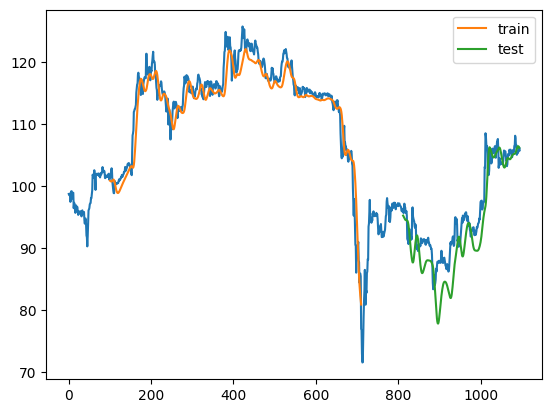

In [29]:
plt.plot(scaler.inverse_transform(df_Close_scaled))
plt.plot(trainPredictPlot, label = 'train')
plt.plot(testPredictPlot, label = 'test')
plt.legend()
plt.show()